In [139]:
import os
from pathlib import Path
import pandas as pd
from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from dotenv import load_dotenv
load_dotenv()
analyzer = SentimentIntensityAnalyzer()

In [140]:
# news api for collecting data
api_key = os.getenv("news_api")
newsapi = NewsApiClient(api_key=api_key)

In [141]:
# this code was to perform an initial pull of data from our fidelity export
# we could have incorporated this code (and would have if we had more time), so we left it
filepath = Path("../Project_2/Stocks_MasterList_Test.csv")
stocks_df = pd.read_csv(filepath, parse_dates=True, infer_datetime_format=True)
stocks_df.head()

,Symbol,Company Name,Price Performance (4 Weeks),Sector,Market Capitalization,Binary
0,Test,Test,Test,Test,Test,Test


In [142]:
company_info_df = stocks_df[['Symbol', 'Company Name']].copy()
company_info_df.head()

,Symbol,Company Name
0,Test,Test


In [143]:
search_list = []

for index, row in company_info_df.iterrows():
    ticker = row['Symbol']
    company_name = row['Company Name']
    search_string = ticker + ' ' + "AND" + ' ' + company_name
    search_list.append(search_string)

print(search_list)

['Test AND Test']


In [144]:
# the below "search_list" was a list of ~90ish companies that we knew would process through newsapi.org. 
# we used fidelity to be certain about whether or not each stock had either increased or decreased over the last month
# this function was crucial to processing a large amount of NLP sentiment data

search_list = ['facebook', 
               'apple', 
               'tesla', 
               'google', 
               'palantir', 
               'amc', 
               'amazon', 
               'netflix', 
               'at&t', 
               'nvidia', 
               'pfizer', 
               'moderna', 
               'nikola', 
               'beyond meat', 
               'gamestop', 
               'starbucks', 
               'wells fargo', 
               'salesforce', 
               'microsoft',
               'verizon',    
               'carnival cruise',
               'macys',
               'nordstrom',
               'teladoc',
               'norwegian cruise',
               'peloton',
               'lululemon',
               'wayfair',
               'chevron',
               'royal caribbean cruise',
               'softbank',
               'astraZeneca',
               'johnson & johnson',
               'twitter',
               'costco',
               'zillow',
               'gilead',
               'boeing',
               'okta',
               'nike',
               'home depot',
               'shopify',
               'uber',
               'lyft',
               'doordash',
               'airbnb',
               'paypal',
               'snowflake',
               'quantumscape',
               'activision',
               'draftKings',
               'lordstown',
               'walgreens',
               'spotify',
               'fubotv',
               'northrop grumman',
               'berkshire hathaway',
               'cisco',
               'ebay',
               'qualcomm',
               'corning',
               'oracle',
               'intel',
               'seagate',
               'nextera',
               'zscaler',
               'crowdstrike',
               'redfin',
               'roblox',
               'citigroup',
               'docusign',
               'amgen',
               'regeneron',
               'medtronic',
               'microsoft',
               'arcelormittal',
               'mattel',
               'schlumberger',
               'ford',
               'intuit',
               'pepsi',
               'stryker',
               'walmart',
               'hasbro',
               'novartis',
               'toyota',
               'mastercard',
               'fortinet',
               'groupon',
               'autodesk',
               'serviceNow',
               'fireeye',
               'proofpoint',
               'qualys',
               'fastly']

# begin the actual function for NLP
final_sentiment_df = pd.DataFrame(columns=['name', 'compound', 'positive', 'negative', 'neutral'])
company_sentiments = []

# after having run the our NLP function on the list below, I am applying the "#" so it does not run everytime we test the code

#for search_string in search_list:
    #company_headlines = newsapi.get_everything(
        q = search_string, 
        language = "en", 
        page_size = 100,
        sort_by = "relevancy")

    for article in company_headlines["articles"]:
        try: 
            text = article["content"]
            date = article["publishedAt"][:10] 
            sentiment = analyzer.polarity_scores(text)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]
        
            company_sentiments.append({
                "text": text,
                "date": date,
                "compound": compound,
                "positive": pos,
                "negative": neg,
                "neutral": neu})
        except AttributeError:
            pass
            
    sentiment_df = pd.DataFrame(company_sentiments) 
    cols = ["date", "text", "compound", "positive", "negative", "neutral"]
    sentiment_df = sentiment_df[cols]
    sentiment_stats_df = sentiment_df.describe()
    sentiment_stats_df.reset_index(drop=True, inplace=True)
    
    not_final_sentiment_df = pd.DataFrame()
    not_final_sentiment_df["name"] = [search_string]
    not_final_sentiment_df["compound"] = [sentiment_stats_df.loc[1]['compound']]
    not_final_sentiment_df["positive"] = [sentiment_stats_df.loc[1]['positive']]
    not_final_sentiment_df["negative"] = [sentiment_stats_df.loc[1]['negative']]
    not_final_sentiment_df["neutral"] = [sentiment_stats_df.loc[1]['neutral']]
    
    final_sentiment_df = final_sentiment_df.append(not_final_sentiment_df, ignore_index=True)
    
print(final_sentiment_df)

IndentationError: unexpected indent (<ipython-input-144-65ac81522f58>, line 109)

In [25]:
# export to csv so we can build a concrete data set to work off of for our model building
# final_sentiment_df.to_csv(r'../Project_2/final_sentiment_df.csv')

In [145]:
# now importing our final data set on which we are going to build the model
filepath = Path("../Project_2/monthly_modeling_df.csv")
monthly_model_df = pd.read_csv(filepath, parse_dates=True, infer_datetime_format=True)
monthly_model_df.head()

,name,compound,positive,negative,neutral,sector,market cap,target
0,facebook,0.079503,0.054388,0.034112,0.911541,Communication Services,827,1
1,apple,0.113186,0.057615,0.030918,0.911482,Information Technology,2019,0
2,tesla,0.118182,0.057990,0.030068,0.908539,Consumer Discretionary,629,0
3,google,0.143941,0.062779,0.029588,0.905092,Communication Services,1380,1
4,palantir,0.153429,0.064429,0.029014,0.904505,Information Technology,44,1


In [146]:
# BEGIN MODEL BUILD
# Note: our sentiments were pulled as of 3/20/21
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [147]:
X = monthly_model_df.drop(columns=['name', 'target'])
X = pd.get_dummies(X, columns=['sector'])
y = monthly_model_df["target"].ravel()
X.describe()

,compound,positive,negative,neutral,market cap,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,0.179529,0.073554,0.030194,0.895735,196.263158,0.094737,0.021053,0.273684,0.052632,0.021053,0.021053,0.115789,0.063158,0.294737,0.010526,0.021053,0.010526
std,0.018270,0.003817,0.001706,0.003793,382.097019,0.294405,0.144321,0.448214,0.224481,0.144321,0.144321,0.321670,0.244537,0.458343,0.102598,0.144321,0.102598
min,0.079503,0.054388,0.026685,0.886778,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173821,0.073207,0.028921,0.893678,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.178965,0.074267,0.030807,0.894877,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.190125,0.074905,0.031587,0.896880,193.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,0.219618,0.082198,0.034112,0.911541,2019.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [148]:
# if stock went up, 1
# if stock went down, 0
monthly_model_df['target'].value_counts()

1    52
0    43
Name: target, dtype: int64

In [149]:
# data pre-processing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [151]:
# now look at different models (we are looking at linear regression (11.1), ensemble (11.2 for "weak" learners), SMOTE (11.3 oversampling for low "0's"), neuearl network to test for comparison)

In [152]:
#1 ensemble learner - Easy Ensemble Classifier

In [153]:
from imblearn.ensemble import EasyEnsembleClassifier
eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec_model = eec_model.fit(X_train_scaled, y_train)
predictions = eec_model.predict(X_test_scaled)

In [154]:
balanced_accuracy_score(y_test, predictions)

0.4583333333333333

In [155]:
confusion_matrix(y_test, predictions)

array([[3, 9],
       [4, 8]], dtype=int64)

In [156]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.43      0.25      0.67      0.32      0.41      0.16        12
          1       0.47      0.67      0.25      0.55      0.41      0.17        12

avg / total       0.45      0.46      0.46      0.43      0.41      0.17        24



In [157]:
#2 resampling - SMOTE oversampling

In [158]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=1)
X_resampled, y_resampled = smt.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({0: 40, 1: 40})

In [159]:
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [160]:
y_pred = model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.5416666666666667

In [161]:
confusion_matrix(y_test, y_pred)

array([[6, 6],
       [5, 7]], dtype=int64)

In [162]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.55      0.50      0.58      0.52      0.54      0.29        12
          1       0.54      0.58      0.50      0.56      0.54      0.29        12

avg / total       0.54      0.54      0.54      0.54      0.54      0.29        24



In [163]:
#3 logistic regression

In [164]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [165]:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(multi_class='warn', random_state=1)

In [166]:
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [167]:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(multi_class='warn', random_state=1)

In [96]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6901408450704225
Testing Data Score: 0.7083333333333334


In [168]:
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,1,1
1,1,1
2,0,0
3,1,1
4,1,0
5,1,0
6,0,1
7,1,0
8,1,1
9,0,0


In [102]:
confusion_matrix(y_test, predictions)

array([[ 7,  5],
       [ 2, 10]], dtype=int64)

In [169]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.67      0.83      0.74        12

    accuracy                           0.71        24
   macro avg       0.72      0.71      0.70        24
weighted avg       0.72      0.71      0.70        24



In [187]:
#4 neural network 

In [188]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
%matplotlib inline

In [189]:
tf.random.set_seed(95)

In [190]:
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

number_inputs = 17
number_hidden_nodes = 69

nn = Sequential()
nn.add(Dense(units=number_hidden_nodes, input_dim=number_inputs, activation="relu"))
nn.add(Dense(1, activation="sigmoid"))
nn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 69)                1242      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 70        
Total params: 1,312
Trainable params: 1,312
Non-trainable params: 0
_________________________________________________________________


In [191]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [192]:
model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.6106
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.6669
Epoch 3/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6547 - accuracy: 0.6622
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.7005
Epoch 5/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.6615
Epoch 6/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6285 - accuracy: 0.7310
Epoch 7/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6250 - accuracy: 0.6810
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 0.6232 - accuracy: 0.6662
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6140 - accuracy: 0.6849
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 0.6032 - accuracy: 0.6888
Epoch 11/100
3/3 [===========

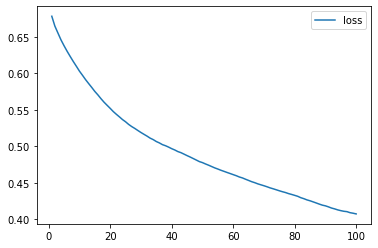

In [193]:
df_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))
df_plot.plot(y="loss")

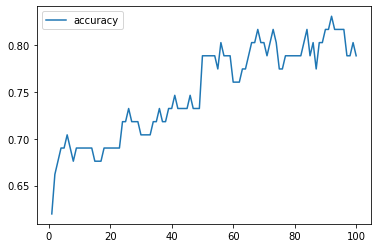

In [194]:
df_plot.plot(y="accuracy")

In [195]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1/1 - 0s - loss: 0.7569 - accuracy: 0.5417
Loss: 0.756915807723999, Accuracy: 0.5416666865348816
